Data Source info and download:
https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification


## Notebook content
This notebook contains the entire commented process of a classification model development from zero to finish.<br>
In particular it contains (in order):
- Data preliminary analysis for dataset comprehension
- Dataset split
- Features engineering
- Baseline model creation
- Model selection (by ranking)
- Hyperparameters tuning
- Metrics analysis
- Out of Sample metrics robstness performance test
- Conclusions and observations until here
- Pipeline creation and saving in local folder

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.utils import all_estimators
import warnings
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from joblib import dump

In [52]:
df = pd.read_csv('fetal_health.csv')

In [53]:
pd.set_option('max_columns', None)
df

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,7.2,40.0,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,7.1,66.0,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,6.1,67.0,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,7.0,66.0,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


In [54]:
df.groupby('fetal_health').count()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
fetal_health,,,,,,,,,,,,,,,,,,,,,
1.0,1655,1655,1655,1655,1655,1655,1655,1655,1655,1655,1655,1655,1655,1655,1655,1655,1655,1655,1655,1655,1655
2.0,295,295,295,295,295,295,295,295,295,295,295,295,295,295,295,295,295,295,295,295,295
3.0,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176


#### Classes are unbalanced, I'm going to use a F1-score weighted to manage this.

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

#### There are no NaN values and all columns type are correctly assigned (float64). No NaNs management or recasting is needed.

#### Let's give a look at all features distribution with a compact boxplot

<AxesSubplot:>

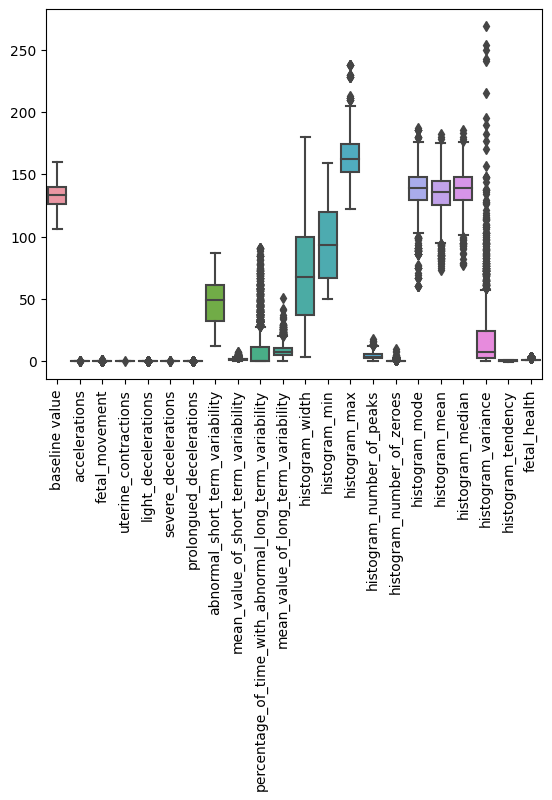

In [56]:
plot = sns.boxplot(data=df)
plt.setp(plot.get_xticklabels(), rotation=90)
plot

### I'm going to Standardize the dataset (StandardScaler) because some of the features have very long tails and I don't want to 'lose' this property in the scaled df.

Get columns names

In [57]:
df.columns

Index(['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',
       'fetal_health'],
      dtype='object')

In [58]:
# Create the scaler object
scaler = StandardScaler()

# Select the columns to scale
cols_to_scale = ['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency']

df_scaled = scaler.fit_transform(df[cols_to_scale])

df_scaled = pd.DataFrame(df_scaled, columns=['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency'])
df_scaled['fetal_health'] = df['fetal_health']
df_scaled

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,-1.352220,-0.822388,-0.203210,-1.482465,-0.638438,-0.057476,-0.268754,1.513190,-0.943095,1.802542,-1.028560,-0.165507,-1.068562,-2.119592,-0.701397,-0.458444,-1.065614,0.153270,-1.181642,1.870569,1.112980,2.0
1,-0.132526,0.730133,-0.203210,0.554627,0.375243,-0.057476,-0.268754,-1.744751,0.868841,-0.535361,0.393176,1.529124,-0.865539,1.893794,0.655137,0.958201,0.216638,0.089126,0.132038,-0.234998,-0.524526,1.0
2,-0.030884,-0.046128,-0.203210,1.233657,0.375243,-0.057476,-0.268754,-1.802928,0.868841,-0.535361,0.926327,1.529124,-0.865539,1.893794,0.316003,0.958201,0.216638,0.024982,-0.006244,-0.200481,-0.524526,1.0
3,0.070757,-0.046128,-0.203210,1.233657,0.375243,-0.057476,-0.268754,-1.802928,1.208579,-0.535361,2.632411,1.195333,-1.373097,0.333033,2.350804,-0.458444,-0.027600,-0.039162,-0.075385,-0.200481,1.112980,1.0
4,-0.132526,0.988886,-0.203210,1.233657,-0.638438,-0.057476,-0.268754,-1.802928,1.208579,-0.535361,2.081488,1.195333,-1.373097,0.333033,1.672537,-0.458444,-0.027600,0.089126,-0.006244,-0.269516,1.112980,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,0.680604,-0.822388,-0.203210,0.894142,-0.638438,-0.057476,-0.268754,1.862255,-1.282833,0.823885,-0.175519,-0.781736,1.469229,0.723223,-0.023130,-0.458444,0.949354,0.987141,0.961731,-0.580173,-0.524526,2.0
2122,0.680604,-0.563635,-0.203210,0.894142,-0.638438,-0.057476,-0.268754,1.804078,-1.056341,0.660775,-0.193290,-0.114154,0.318764,0.277292,0.655137,-0.458444,0.888294,0.858853,0.892590,-0.545656,1.112980,2.0
2123,0.680604,-0.563635,-0.203210,0.894142,-0.638438,-0.057476,-0.268754,1.862255,-1.056341,0.552035,-0.371007,-0.088478,0.318764,0.333033,0.316003,-0.458444,0.949354,0.858853,0.961731,-0.511138,1.112980,2.0
2124,0.680604,-0.563635,-0.203210,0.554627,-0.638438,-0.057476,-0.268754,1.804078,-1.056341,0.932624,-0.211062,-0.114154,0.318764,0.277292,0.655137,-0.458444,0.888294,0.794709,0.892590,-0.511138,1.112980,2.0


<AxesSubplot:>

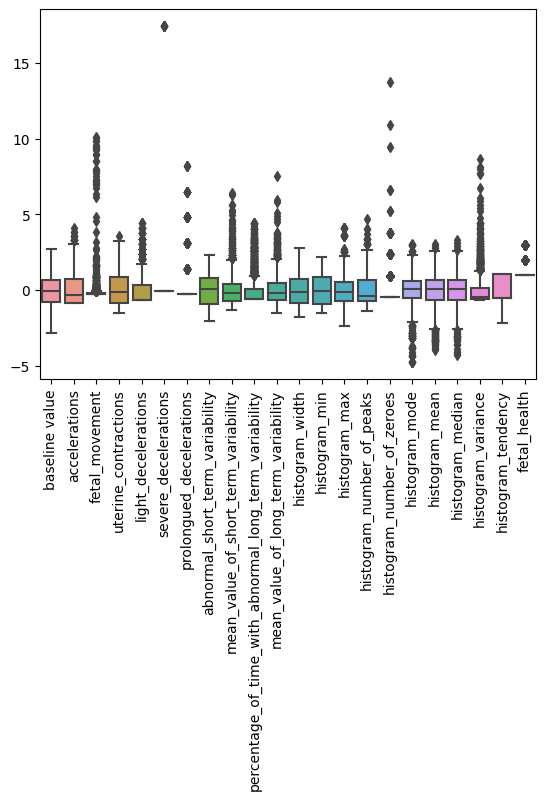

In [59]:
plot = sns.boxplot(data=df_scaled)
plt.setp(plot.get_xticklabels(), rotation=90)
plot

## Let's start the modeling phase!
#### Dataset split between development and validation subsets
Once the two sets of data are split we can scale them separately 
(doing otherwise would erroneously create a statistical relationship that shouldn't exist
between the two datasets!)

In [60]:
#import df
df = pd.read_csv('fetal_health.csv')

# Define the feature columns
feature_cols = ['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency']

# Define the target column
target_col = 'fetal_health'

# Splitting data into training and test sets
X = df[feature_cols]
y = pd.DataFrame(df[target_col])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Initialize the scaler
scaler = StandardScaler()

# Transform the training data
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_cols).reset_index(drop=True)

# Transform the test data
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=feature_cols).reset_index(drop=True)

y_train = pd.DataFrame(y_train, columns=[target_col]).reset_index(drop=True)
y_test = pd.DataFrame(y_test, columns=[target_col]).reset_index(drop=True)


#development dataset creation
df_dev_scaled = pd.concat([X_train, y_train], axis=1)


#validation dataset creation
df_val_scaled = pd.concat([X_test, y_test], axis=1)


#### I will keep working on the development dataset from this moment on and will use the validation dataset only to final test the robustness of the metrics.
#### Let's furtherly split the development dataset into train and test

In [61]:
X = df_dev_scaled.drop(columns=['fetal_health'])
y = df_dev_scaled[['fetal_health']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Create a baseline model to compare the improvements later in the process

In [62]:
# create the decision tree classifier
clf = DecisionTreeClassifier()

# create the f1_weighted scoring function
f1_scorer = make_scorer(f1_score, average='weighted')

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print("Weighted F1-score:", weighted_f1)
print(classification_report(y_test, y_pred))



Weighted F1-score: 0.932352999481089
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96       265
         2.0       0.81      0.83      0.82        47
         3.0       0.92      0.86      0.89        28

    accuracy                           0.93       340
   macro avg       0.90      0.88      0.89       340
weighted avg       0.93      0.93      0.93       340



### My Reference Weighted F1_score is 0,92 (pretty high already!). Let's try to improve it! :-)</p>
As first approach I'm going to compare various classification models set with their default hypermarameters in order to select the best performer.

In [63]:
warnings.simplefilter("ignore")

for name, clf in all_estimators(type_filter='classifier'):
    try:
        clf = clf()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        weighted_f1 = f1_score(y_test, y_pred, average='weighted')
        print(name, "Weighted F1-score:", round(weighted_f1,2))
    except:
        pass


AdaBoostClassifier Weighted F1-score: 0.86
BaggingClassifier Weighted F1-score: 0.93
BernoulliNB Weighted F1-score: 0.84
CalibratedClassifierCV Weighted F1-score: 0.9
DecisionTreeClassifier Weighted F1-score: 0.93
DummyClassifier Weighted F1-score: 0.68
ExtraTreeClassifier Weighted F1-score: 0.88
ExtraTreesClassifier Weighted F1-score: 0.94
GaussianNB Weighted F1-score: 0.87
GaussianProcessClassifier Weighted F1-score: 0.92
GradientBoostingClassifier Weighted F1-score: 0.95
HistGradientBoostingClassifier Weighted F1-score: 0.96
KNeighborsClassifier Weighted F1-score: 0.89
LabelPropagation Weighted F1-score: 0.92
LabelSpreading Weighted F1-score: 0.92
LinearDiscriminantAnalysis Weighted F1-score: 0.89
LinearSVC Weighted F1-score: 0.91
LogisticRegression Weighted F1-score: 0.92
LogisticRegressionCV Weighted F1-score: 0.91
MLPClassifier Weighted F1-score: 0.92
NearestCentroid Weighted F1-score: 0.8
PassiveAggressiveClassifier Weighted F1-score: 0.89
Perceptron Weighted F1-score: 0.9
Quadr

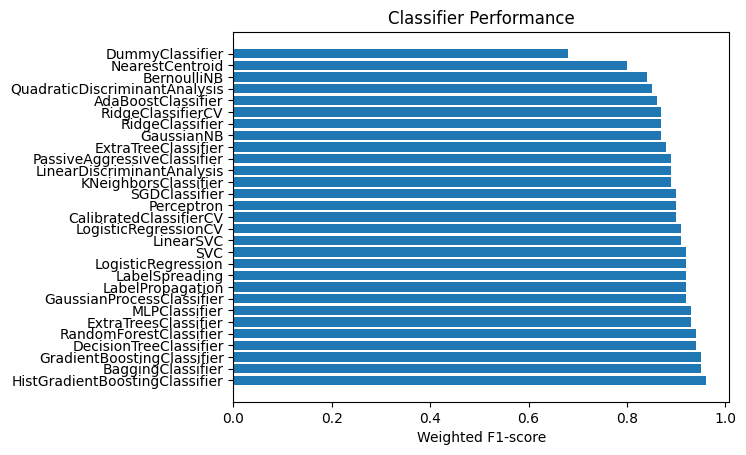

In [64]:
warnings.simplefilter("ignore")

results = {}
for name, clf in all_estimators(type_filter='classifier'):
    try:
        clf = clf()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        weighted_f1 = f1_score(y_test, y_pred, average='weighted')
        results[name] = round(weighted_f1, 2)
    except:
        pass

    # Bar chart
results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
plt.barh(range(len(results)), list(results.values()), align='center')
plt.yticks(range(len(results)), list(results.keys()))
plt.xlabel('Weighted F1-score')
plt.title('Classifier Performance')
plt.show()


The best performers are:
<br> - GradientBoostingClassifier Weighted F1-score: 0.95
<br> - HistGradientBoostingClassifier Weighted F1-score: 0.96




GradientBoostingClassifier and HistGradientBoostingClassifier are the best performers. In order to have a better comprehension of the models performances distribution I'm going to run a cross_validation with them and plot the results through a boxplot.

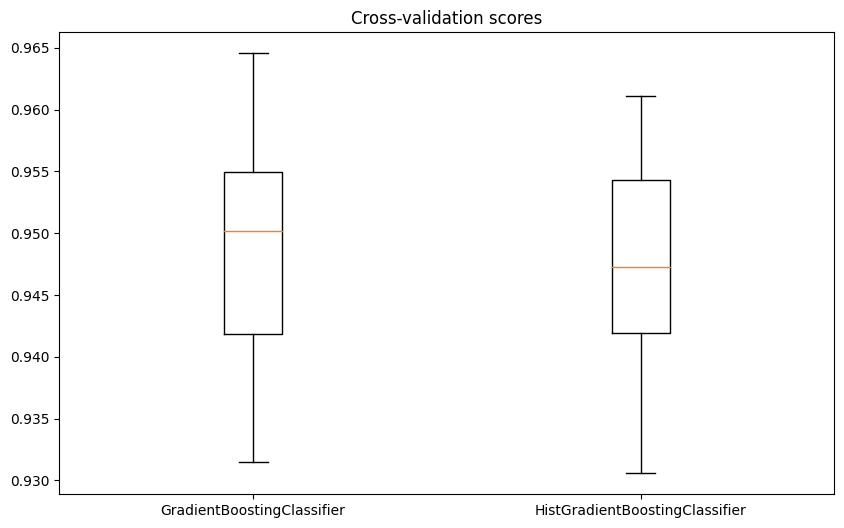

In [65]:
# Instantiate models
GBC = GradientBoostingClassifier()
HGBC = HistGradientBoostingClassifier()
models = [GBC, HGBC]

# Create cross-validation object
cv = ShuffleSplit(n_splits=20, test_size=0.25, random_state=0)

# Calculate the scores for each model
scores = {}
for model in models:
    model_name = str(model).split("(")[0]
    scores[model_name] = cross_val_score(model, X_train, y_train, scoring='f1_weighted', cv=cv)

# boxplot creation
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(scores.values(), labels=scores.keys())
ax.set_title("Cross-validation scores")
plt.show()

#### The GradientBoostingClassifier model seems to perform a bit better. I will use this model from this moment on for the next steps.

### Hyper parameters tuning

In [66]:
# Create a GradientBoostingClassifier object
gbc = GradientBoostingClassifier()

# Define the grid of hyperparameters to search
param_grid = {'n_estimators': [200, 400, 600],
              'learning_rate': [0.01, 0.1, 0.2],
              'max_depth': [1, 2, 3]}

# Perform the grid search
grid_search = GridSearchCV(gbc, param_grid, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Best parameters:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 400}
Best score:  0.9568473034716616


#### Save best estimator

In [67]:
GBC_best = grid_search.best_estimator_

#### Check the improvements between the model tuned and the model with default parameters

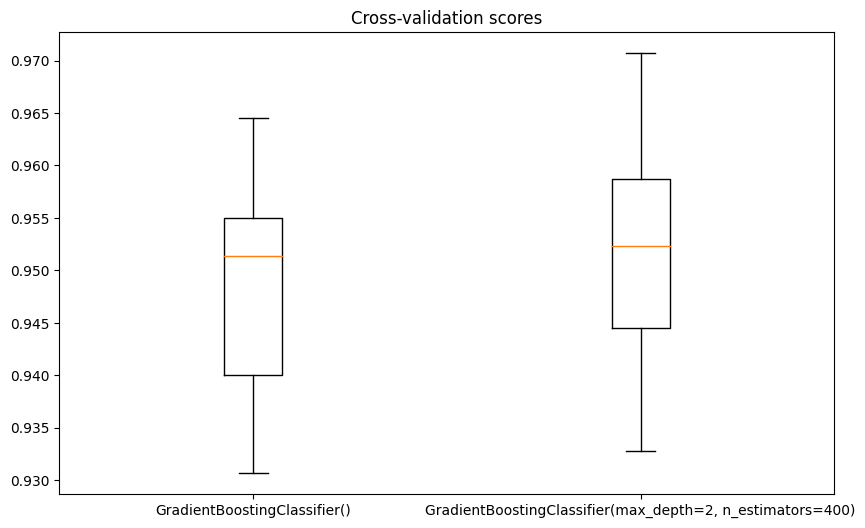

In [68]:
# Instantiate models
GBC = GradientBoostingClassifier()
GBC_best = GBC_best
models = [GBC, GBC_best]

# Create cross-validation object
cv = ShuffleSplit(n_splits=20, test_size=0.25, random_state=0)

# Calculate the scores for each model
scores = {}
for model in models:
    model_name = str(model)
    scores[model_name] = cross_val_score(model, X_train, y_train, scoring='f1_weighted', cv=cv)

# boxplot creation
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(scores.values(), labels=scores.keys())
ax.set_title("Cross-validation scores")
plt.show()

#### The tuned model seems to perform slightly better than the one with default parameters.

### Let's check the performances of the model in out of sample using the test set.

#### Split dataset with validation set

In [69]:
X_train = df_dev_scaled.drop(columns=target_col)
y_train = df_dev_scaled[['fetal_health']]
X_test = df_val_scaled.drop(columns=target_col)
y_test = df_val_scaled[['fetal_health']]


#### Run the tuned model and get metrics

In [70]:
GBC_default = GradientBoostingClassifier()
GBC_best = GBC_best

GBC_default.fit(X_train,y_train)
y_pred = GBC_default.predict(X_test)
f1_weighted_score = f1_score(y_test, y_pred, average='weighted')
print('GBC_default f1 weighted score is: ',round(f1_weighted_score,3))

GBC_best.fit(X_train,y_train)
y_pred = GBC_best.predict(X_test)
f1_weighted_score = f1_score(y_test, y_pred, average='weighted')
print('GBC_best f1 weighted score is: ',round(f1_weighted_score,3))
print('Classification report of GBC_best:')
print(classification_report(y_test, y_pred))



GBC_default f1 weighted score is:  0.902
GBC_best f1 weighted score is:  0.918
Classification report of GBC_best:
              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96       332
         2.0       0.88      0.61      0.72        59
         3.0       0.84      0.89      0.86        35

    accuracy                           0.92       426
   macro avg       0.88      0.83      0.85       426
weighted avg       0.92      0.92      0.92       426



#### Plot the learning curve of "GBC_best" model

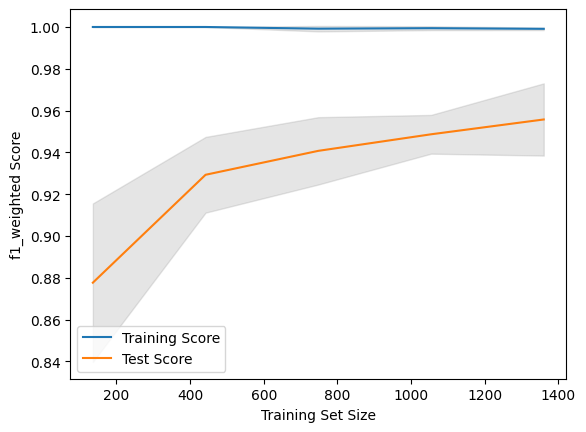

In [71]:
train_sizes, train_scores, test_scores = learning_curve(GBC_best, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)

# Calculate the mean and standard deviation of the training scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate the mean and standard deviation of the test scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Test Score')

# Add the standard deviation of the scores to the plot
plt.fill_between(train_sizes, train_mean - 2*train_std, train_mean + 2*train_std, color='gray', alpha=0.2)
plt.fill_between(train_sizes, test_mean - 2*test_std, test_mean + 2*test_std, color='gray', alpha=0.2)

plt.xlabel('Training Set Size')
plt.ylabel('f1_weighted Score')
plt.legend()
plt.show()


### Conclusions:
Below the conclusion that we can get looking at the metrics values, the classification report and the learning curves:
- The performance of the model in Out Of Sample is consistent with the performance In-sample (f1_weighted passes from 0,95 to 0,92). 
- Looking at the learning curve plot it is safe to assume that this difference can be PARTIALLY explained in terms of noise of the metric
- Looking at how the training score converges to the test score in the learning curve plot, it is also safe to assume that with a larger training dataset this gap would reduce. 
- The choice of using the f1_weighted metric was good, infact the f1-score remains relatively high on each class despite the class 2 or 3 have a considerably lower support than class 1.<br><br>

### Finally
The model is the best performer among the tested models, hyperparameters were tuned and the only way to improve consistently the OOS performance is to increase the training set, which now is not possible. So we can stop here the modeling phase since there is nothing that can reasonably be done under these conditions and without a larger dataset (excluding further hyperparameters tuning that we are not going to explore here).

### Let' create the pipeline!

In [72]:
#import df
df = pd.read_csv('fetal_health.csv')

# Define the feature columns
feature_cols = ['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency']

# Define the target column
target_col = 'fetal_health'

# Splitting data into training and test sets
X = df[feature_cols]
y = pd.DataFrame(df[target_col])

# initialize column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency'])
    ])

# initialize pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GBC_best)
])

# train pipeline on all data
pipe.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['baseline value',
                                                   'accelerations',
                                                   'fetal_movement',
                                                   'uterine_contractions',
                                                   'light_decelerations',
                                                   'severe_decelerations',
                                                   'prolongued_decelerations',
                                                   'abnormal_short_term_variability',
                                                   'mean_value_of_short_term_variability',
                                                   'percentage_of_time_with_abnormal_long_term_variability',
                                                   'mean_value_of_long_term_variability',
                                                   'histogram_width',
                                                   'histogram_min',
                                                   'histogram_max',
                                                   'histogram_number_of_peaks',
                                                   'histogram_number_of_zeroes',
                                                   'histogram_mode',
                                                   'histogram_mean',
                                                   'histogram_median',
                                                   'histogram_variance',
                                                   'histogram_tendency'])])),
                ('model',
                 GradientBoostingClassifier(max_depth=2, n_estimators=400))])

#### Last check to verify that the pipeline produces exactly the same results of the "GBC_best" model if run on the same data

In [73]:
X_train = df_dev_scaled.drop(columns=target_col)
y_train = df_dev_scaled[['fetal_health']]
X_test = df_val_scaled.drop(columns=target_col)
y_test = df_val_scaled[['fetal_health']]

pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
f1_weighted_score = f1_score(y_test, y_pred, average='weighted')
print('pipe f1 weighted score is: ',round(f1_weighted_score,3))
print('Classification report of pipe:')
print(classification_report(y_test, y_pred))




pipe f1 weighted score is:  0.918
Classification report of pipe:
              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96       332
         2.0       0.88      0.61      0.72        59
         3.0       0.84      0.89      0.86        35

    accuracy                           0.92       426
   macro avg       0.88      0.83      0.85       426
weighted avg       0.92      0.92      0.92       426



## Outcome is perfectly overlapping!

#### Export and save pipeline

In [74]:
# export pipeline
dump(pipe, 'pipeline_Fetal_Health.joblib')

['pipeline_Fetal_Health.joblib']